In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch_geometric.nn import GCNConv, GATConv

import numpy as np
import pandas as pd
import glob

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from math import radians, sin, cos, sqrt, atan2
from sklearn.neighbors import NearestNeighbors

# Data Loading

In [45]:
# Folder path with CSV files
folder_path = 'overall_binarized_outputs/'

# Load all CSV files (named like subset_lat_lon.csv)
csv_files = glob.glob(folder_path + '*.csv')

station_data = {}

for file in csv_files:
    # Extract station id from filename (e.g., 'subset_19.25_73.00.csv')
    station_id = file.split('/')[-1].replace('.csv', '')  # 'subset_lat_lon'

    # Load CSV, parse dates if date column exists, else just load normally
    df = pd.read_csv(file)

    # Sort by date if 'date' column exists, else assume already sorted
    if 'date' in df.columns:
        df = df.sort_values('date').reset_index(drop=True)

    station_data[station_id] = df

# All CSVs have same dates and rows = 701, so no need for intersection
num_stations = len(station_data)
num_days = 615  # as given

# Identify feature columns (all except 'Rainfall' and 'date' if exists)
sample_df = next(iter(station_data.values()))
feature_cols = [col for col in sample_df.columns if col not in ['Rainfall', 'date']]

num_features = len(feature_cols)

# Initialize arrays
X = np.zeros((num_days, num_stations, num_features))
Y = np.zeros((num_days, num_stations))

# Fill arrays
for i, station_id in enumerate(sorted(station_data.keys())):
    df = station_data[station_id]
    X[:, i, :] = df[feature_cols].values
    Y[:, i] = df['Rainfall'].values

# Normalize features globally across all time and stations
scaler = StandardScaler()
X_reshaped = X.reshape(-1, num_features)
X_scaled = scaler.fit_transform(X_reshaped)
X = X_scaled.reshape(num_days, num_stations, num_features)

print(f"Loaded data: Features shape {X.shape}, Labels shape {Y.shape}")


Loaded data: Features shape (615, 45, 184), Labels shape (615, 45)


In [47]:
# Extract lat/lon from sorted station ids
station_ids = sorted(station_data.keys())
station_coords = []

for station_id in station_ids:
    # filename format: 'subset_lat_lon' or possibly with more underscores
    parts = station_id.split('_')
    lat_str, lon_str = parts[-2], parts[-1]
    lat, lon = float(lat_str), float(lon_str)
    station_coords.append((lat, lon))

station_coords = np.array(station_coords)  # shape: (30, 2)

# Function to compute Haversine distance matrix
def haversine_distances(coords):
    R = 6371  # Earth radius in km
    n = coords.shape[0]
    dists = np.zeros((n, n))
    for i in range(n):
        lat1, lon1 = map(radians, coords[i])
        for j in range(n):
            lat2, lon2 = map(radians, coords[j])
            dlat = lat2 - lat1
            dlon = lon2 - lon1
            a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
            c = 2 * atan2(sqrt(a), sqrt(1 - a))
            dists[i, j] = R * c
    return dists

# Compute distance matrix
dist_matrix = haversine_distances(station_coords)

# Create edges using top-K nearest neighbors (excluding self)
K = 15
edge_index = []

for i in range(dist_matrix.shape[0]):
    neighbors = np.argsort(dist_matrix[i])[1:K+1]  # skip self (index 0)
    for j in neighbors:
        edge_index.append([i, j])  # i --> j

# Convert to PyTorch tensor
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

print(f"Edge index shape: {edge_index.shape}")  # should be (2, num_edges)


Edge index shape: torch.Size([2, 675])


In [48]:
# Convert to torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)  # shape: (701, 30, 186)
Y_tensor = torch.tensor(Y, dtype=torch.long)     # shape: (701, 30)

# Example: Get data for time step t
t = 0  # any value from 0 to 700
X_t = X_tensor[t]      # shape: (30, 186)
Y_t = Y_tensor[t]      # shape: (30,)

print(f"X_t shape: {X_t.shape}, Y_t shape: {Y_t.shape}")



class GNNDailyDataset(Dataset):
    def __init__(self, X_tensor, Y_tensor):
        self.X = X_tensor  # shape: (701, 30, 186)
        self.Y = Y_tensor  # shape: (701, 30)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]  # X_t: (30, 186), Y_t: (30,)

# Create dataset
gnn_dataset = GNNDailyDataset(X_tensor, Y_tensor)

# Example usage
X_t, Y_t = gnn_dataset[0]
print(X_t.shape, Y_t.shape)


X_t shape: torch.Size([45, 184]), Y_t shape: torch.Size([45])
torch.Size([45, 184]) torch.Size([45])


In [49]:
sequence_length = 14  # L = 7

X_sequences = []
Y_targets = []

for t in range(len(X_tensor) - sequence_length):
    # Input: days t to t+L-1 (shape: L, 30, 186)
    X_seq = X_tensor[t : t + sequence_length]  # (7, 30, 186)
    Y_target = Y_tensor[t + sequence_length]   # (30,)
    
    X_sequences.append(X_seq)
    Y_targets.append(Y_target)

# Convert to torch tensors
X_sequences = torch.stack(X_sequences)  # shape: (N, 7, 30, 186)
Y_targets = torch.stack(Y_targets)      # shape: (N, 30)

print(f"X_sequences shape: {X_sequences.shape}, Y_targets shape: {Y_targets.shape}")

from torch.utils.data import Dataset

class GNNSequenceDataset(Dataset):
    def __init__(self, X_seq, Y_target):
        self.X = X_seq      # (N, 7, 30, 186)
        self.Y = Y_target   # (N, 30)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Create dataset
gnn_seq_dataset = GNNSequenceDataset(X_sequences, Y_targets)



X_sequences shape: torch.Size([601, 14, 45, 184]), Y_targets shape: torch.Size([601, 45])


In [50]:
# Total number of sequences
total = len(X_sequences)

# Compute sizes
train_size = int(0.7 * total)
val_size = int(0.15 * total)
test_size = total - train_size - val_size

# Create temporal splits
X_train = X_sequences[:train_size]
Y_train = Y_targets[:train_size]

X_val = X_sequences[train_size:train_size + val_size]
Y_val = Y_targets[train_size:train_size + val_size]

X_test = X_sequences[train_size + val_size:]
Y_test = Y_targets[train_size + val_size:]

from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)
test_dataset = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Model Architecture
- #### GCN + Transformer

In [51]:
class GNN_LSTM_RainPredictor(nn.Module):
    def __init__(self, in_feats, hidden_gnn, hidden_transformer, num_heads, num_layers):
        super().__init__()
        self.num_nodes = 30
        self.hidden_gnn = hidden_gnn
        self.hidden_transformer = hidden_transformer

        # GCN layer
        self.gcn = GCNConv(in_feats, hidden_gnn)

        # Positional encoding for time steps
        self.pos_embedding = nn.Parameter(torch.randn(1, 100, hidden_gnn))  # Max sequence length = 100

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_gnn,
            nhead=num_heads,
            dim_feedforward=hidden_transformer,
            batch_first=True,
            dropout=0.1,
            norm_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Final classification layer
        self.fc = nn.Linear(hidden_gnn, 1)

    def forward(self, X_seq, edge_index):
        B, L, N, F = X_seq.size()
        outputs = []

        for t in range(L):
            X_t = X_seq[:, t]  # (B, N, F)
            X_t_flat = X_t.reshape(B * N, F)
            edge_index_batch = self._batch_edge_index(edge_index, B, N)
            gnn_out = self.gcn(X_t_flat, edge_index_batch)  # (B*N, hidden_gnn)
            gnn_out = torch.relu(gnn_out)
            gnn_out = gnn_out.view(B, N, self.hidden_gnn)
            outputs.append(gnn_out)

        # Stack: (B, L, N, H) → (B*N, L, H)
        spatial_seq = torch.stack(outputs, dim=1).transpose(1, 2).reshape(B * N, L, self.hidden_gnn)

        # Add positional encoding (truncate if sequence longer than 100)
        max_len = self.pos_embedding.size(1)
        if L > max_len:
            raise ValueError(f"Sequence length {L} exceeds max supported {max_len} for positional encoding.")
        spatial_seq = spatial_seq + self.pos_embedding[:, :L, :]

        # Pass through transformer
        transformer_out = self.transformer(spatial_seq)  # (B*N, L, H)

        # Pooling: use mean over time
        pooled_out = transformer_out.mean(dim=1)  # (B*N, H)

        # Final prediction
        logits = self.fc(pooled_out).squeeze(-1)
        return logits.view(B, N)

    def _batch_edge_index(self, edge_index, B, N):
        edge_indices = []
        for i in range(B):
            offset = i * N
            edge_indices.append(edge_index + offset)
        return torch.cat(edge_indices, dim=1)


- #### GAT+Transformer

In [55]:
class GNN_LSTM_RainPredictor(nn.Module):
    def __init__(self, in_feats, hidden_gnn, hidden_transformer, num_heads, num_layers, gat_heads=4):
        super().__init__()
        self.num_nodes = 30
        self.hidden_gnn = hidden_gnn
        self.hidden_transformer = hidden_transformer
        self.gat_heads = gat_heads

        # GAT layer
        self.gat = GATConv(in_feats, hidden_gnn // gat_heads, heads=gat_heads, concat=True, dropout=0.1)

        # Positional encoding for time steps
        self.pos_embedding = nn.Parameter(torch.randn(1, 100, hidden_gnn))  # Max sequence length = 100

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_gnn,
            nhead=num_heads,
            dim_feedforward=hidden_transformer,
            batch_first=True,
            dropout=0.1,
            norm_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Final classification layer
        self.fc = nn.Linear(hidden_gnn, 1)

    def forward(self, X_seq, edge_index):
        B, L, N, F = X_seq.size()
        outputs = []

        for t in range(L):
            X_t = X_seq[:, t]  # (B, N, F)
            X_t_flat = X_t.reshape(B * N, F)
            edge_index_batch = self._batch_edge_index(edge_index, B, N)

            # GAT forward pass
            gat_out = self.gat(X_t_flat, edge_index_batch)  # (B*N, hidden_gnn)
            gat_out = torch.relu(gat_out)
            gat_out = gat_out.view(B, N, self.hidden_gnn)
            outputs.append(gat_out)

        # Stack: (B, L, N, H) → (B*N, L, H)
        spatial_seq = torch.stack(outputs, dim=1).transpose(1, 2).reshape(B * N, L, self.hidden_gnn)

        # Add positional encoding
        max_len = self.pos_embedding.size(1)
        if L > max_len:
            raise ValueError(f"Sequence length {L} exceeds max supported {max_len} for positional encoding.")
        spatial_seq = spatial_seq + self.pos_embedding[:, :L, :]

        # Transformer
        transformer_out = self.transformer(spatial_seq)  # (B*N, L, H)
        pooled_out = transformer_out.mean(dim=1)  # (B*N, H)

        # Final prediction
        logits = self.fc(pooled_out).squeeze(-1)
        return logits.view(B, N)

    def _batch_edge_index(self, edge_index, B, N):
        edge_indices = []
        for i in range(B):
            offset = i * N
            edge_indices.append(edge_index + offset)
        return torch.cat(edge_indices, dim=1)


- #### GCN+CNN

In [53]:
class GNN_LSTM_RainPredictor(nn.Module):
    def __init__(self, in_feats, hidden_gnn, hidden_cnn, kernel_size=3):
        super().__init__()
        self.num_nodes = 30
        self.hidden_gnn = hidden_gnn
        self.hidden_cnn = hidden_cnn
        self.kernel_size = kernel_size

        # GCN layer
        self.gcn = GCNConv(in_feats, hidden_gnn)

        # Temporal CNN over the hidden_gnn-dim sequences
        self.temporal_cnn = nn.Sequential(
            nn.Conv1d(in_channels=hidden_gnn, out_channels=hidden_cnn, kernel_size=kernel_size, padding=kernel_size//2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_cnn),
            nn.Conv1d(hidden_cnn, hidden_cnn, kernel_size=kernel_size, padding=kernel_size//2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)  # output shape: (B*N, hidden_cnn, 1)
        )

        # Final prediction layer
        self.fc = nn.Linear(hidden_cnn, 1)

    def forward(self, X_seq, edge_index):
        B, L, N, F = X_seq.size()
        outputs = []

        for t in range(L):
            X_t = X_seq[:, t]  # (B, N, F)
            X_t_flat = X_t.reshape(B * N, F)            
            edge_index_batch = self._batch_edge_index(edge_index, B, N)
            gnn_out = self.gcn(X_t_flat, edge_index_batch)  # (B*N, hidden_gnn)
            gnn_out = torch.relu(gnn_out)
            gnn_out = gnn_out.view(B, N, self.hidden_gnn)
            outputs.append(gnn_out)

        # Stack over time: (B, L, N, H) → (B*N, H, L)
        spatial_seq = torch.stack(outputs, dim=1).permute(0, 2, 3, 1).reshape(B * N, self.hidden_gnn, L)

        # Temporal CNN
        cnn_out = self.temporal_cnn(spatial_seq)  # (B*N, hidden_cnn, 1)
        cnn_out = cnn_out.squeeze(-1)  # (B*N, hidden_cnn)

        # Final prediction
        logits = self.fc(cnn_out).squeeze(-1)
        return logits.view(B, N)

    def _batch_edge_index(self, edge_index, B, N):
        edge_indices = []
        for i in range(B):
            offset = i * N
            edge_indices.append(edge_index + offset)
        return torch.cat(edge_indices, dim=1)


# Training

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = GNN_LSTM_RainPredictor(
    in_feats=184,
    hidden_gnn=64,
    #hidden_cnn=128,
    #kernel_size=3,
    hidden_transformer=128,
    num_heads=4,
    num_layers=2
).to(device)
pos_weight = torch.tensor(85 / 15).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

Using device: cuda


c:\Users\Shubham Sharma\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [68]:
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0
    for X, Y in loader:
        X, Y = X.to(device), Y.float().to(device)
        optimizer.zero_grad()
        preds = model(X, edge_index.to(device))  # (B, 30)
        loss = criterion(preds, Y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def evaluate(model, val_loader, edge_index):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        edge_index = edge_index.to(device)

        for X_seq_batch, labels_batch in val_loader:
            X_seq_batch = X_seq_batch.to(device)
            labels_batch = labels_batch.to(device)

            out = model(X_seq_batch, edge_index)  # Make sure edge_index is accessible
            preds = (out >= 0.3).long()

            all_preds.append(preds)
            all_labels.append(labels_batch)

    all_preds = torch.cat(all_preds, dim=0).view(-1).cpu().numpy()
    all_labels = torch.cat(all_labels, dim=0).view(-1).cpu().numpy()

    acc = accuracy_score(all_labels, all_preds)
    precision_per_class = precision_score(all_labels, all_preds, average=None)
    recall_per_class = recall_score(all_labels, all_preds, average=None)
    f1_per_class = f1_score(all_labels, all_preds, average=None)
    cm = confusion_matrix(all_labels, all_preds)

    return acc, precision_per_class, recall_per_class, f1_per_class, cm




In [64]:
num_epochs = 30

for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(model, train_loader)
    acc, precision_per_class, recall_per_class, f1_per_class, cm = evaluate(model, val_loader,edge_index)

    print(f"[Epoch {epoch}] Loss: {train_loss:.4f} | Val Acc: {acc:.4f}")

    for cls in range(len(precision_per_class)):
        print(
            f"Class {cls} -> Precision: {precision_per_class[cls]:.4f}, "
            f"Recall: {recall_per_class[cls]:.4f}, F1: {f1_per_class[cls]:.4f}"
        )

        print("\nConfusion Matrix:")
        print(cm)

            

[Epoch 1] Loss: 1.0264 | Val Acc: 0.7442
Class 0 -> Precision: 0.9689, Recall: 0.7545, F1: 0.8484

Confusion Matrix:
[[2898  943]
 [  93  116]]
Class 1 -> Precision: 0.1095, Recall: 0.5550, F1: 0.1830

Confusion Matrix:
[[2898  943]
 [  93  116]]
[Epoch 2] Loss: 1.0301 | Val Acc: 0.7412
Class 0 -> Precision: 0.9719, Recall: 0.7488, F1: 0.8459

Confusion Matrix:
[[2876  965]
 [  83  126]]
Class 1 -> Precision: 0.1155, Recall: 0.6029, F1: 0.1938

Confusion Matrix:
[[2876  965]
 [  83  126]]
[Epoch 3] Loss: 1.0456 | Val Acc: 0.6494
Class 0 -> Precision: 0.9618, Recall: 0.6563, F1: 0.7803

Confusion Matrix:
[[2521 1320]
 [ 100  109]]
Class 1 -> Precision: 0.0763, Recall: 0.5215, F1: 0.1331

Confusion Matrix:
[[2521 1320]
 [ 100  109]]
[Epoch 4] Loss: 1.1244 | Val Acc: 0.7336
Class 0 -> Precision: 0.9720, Recall: 0.7404, F1: 0.8405

Confusion Matrix:
[[2844  997]
 [  82  127]]
Class 1 -> Precision: 0.1130, Recall: 0.6077, F1: 0.1905

Confusion Matrix:
[[2844  997]
 [  82  127]]
[Epoch 5] Lo

[Epoch 1] Loss: 0.6828 | Val Acc: 0.7933
[Epoch 2] Loss: 0.6300 | Val Acc: 0.7911
[Epoch 3] Loss: 0.6166 | Val Acc: 0.7247
[Epoch 4] Loss: 0.6218 | Val Acc: 0.7526
[Epoch 5] Loss: 0.6233 | Val Acc: 0.8306
[Epoch 6] Loss: 0.6188 | Val Acc: 0.8321
[Epoch 7] Loss: 0.6325 | Val Acc: 0.7933
[Epoch 8] Loss: 0.6056 | Val Acc: 0.7044
[Epoch 9] Loss: 0.6073 | Val Acc: 0.8067
[Epoch 10] Loss: 0.6150 | Val Acc: 0.8165
[Epoch 11] Loss: 0.6273 | Val Acc: 0.7933
[Epoch 12] Loss: 0.6551 | Val Acc: 0.7363
[Epoch 13] Loss: 0.6138 | Val Acc: 0.7973
[Epoch 14] Loss: 0.5731 | Val Acc: 0.7728
[Epoch 15] Loss: 0.5692 | Val Acc: 0.7667
[Epoch 16] Loss: 0.5635 | Val Acc: 0.8141
[Epoch 17] Loss: 0.5682 | Val Acc: 0.8190
[Epoch 18] Loss: 0.5752 | Val Acc: 0.7965
[Epoch 19] Loss: 0.5718 | Val Acc: 0.7560
[Epoch 20] Loss: 0.5816 | Val Acc: 0.7610
[Epoch 21] Loss: 0.5798 | Val Acc: 0.8373
[Epoch 22] Loss: 0.5896 | Val Acc: 0.8123
[Epoch 23] Loss: 0.6074 | Val Acc: 0.7672
[Epoch 24] Loss: 0.5810 | Val Acc: 0.7538
[

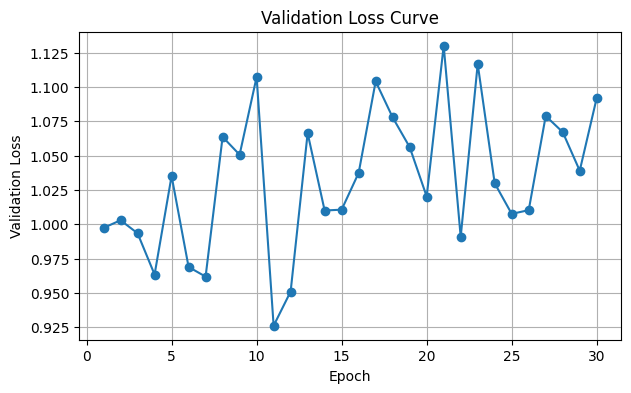

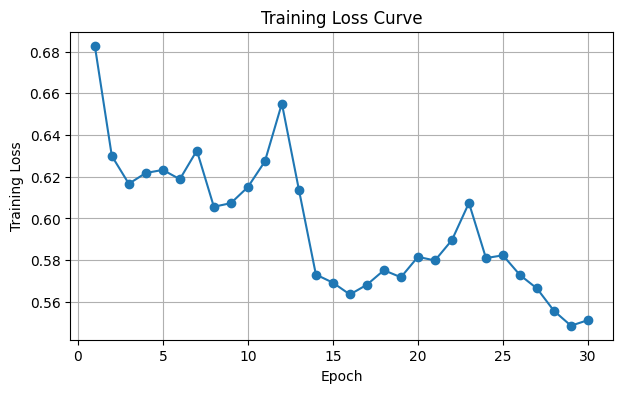

In [70]:
# Collect training and validation losses for each epoch
train_losses = []
val_losses = []

num_epochs = 30

for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(model, train_loader)
    train_losses.append(train_loss)
    acc, precision_per_class, recall_per_class, f1_per_class, cm = evaluate(model, val_loader, edge_index)
    print(f"[Epoch {epoch}] Loss: {train_loss:.4f} | Val Acc: {acc:.4f}")
    # Collect validation loss for each epoch
    val_loss = criterion(model(X_val.to(device), edge_index.to(device)), Y_val.float().to(device)).item()
    val_losses.append(val_loss)

# Plot validation loss curve
plt.figure(figsize=(7, 4))
plt.plot(range(1, num_epochs + 1), val_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss') 
plt.title('Validation Loss Curve')
plt.grid(True)
plt.show()
# Plot training loss curve
plt.figure(figsize=(7, 4))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()

# Evaluation

[Test] Accuracy: 0.7902
Class 0 -> Precision: 0.8671, Recall: 0.8826, F1: 0.8748
Class 1 -> Precision: 0.3707, Recall: 0.3381, F1: 0.3536

Confusion Matrix:
[[3001  399]
 [ 460  235]]


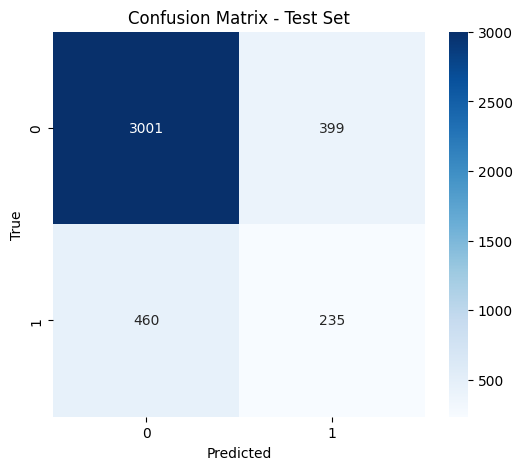


[Derived Metrics]
Hit Rate (Recall): 0.3381
False Alarm Rate: 0.1174
Threat Score: 0.2148


In [65]:
acc, prec_cls, rec_cls, f1_cls, cm = evaluate(model, test_loader, edge_index)

print(f"[Test] Accuracy: {acc:.4f}")
for cls in range(len(prec_cls)):
    print(f"Class {cls} -> Precision: {prec_cls[cls]:.4f}, Recall: {rec_cls[cls]:.4f}, F1: {f1_cls[cls]:.4f}")

print("\nConfusion Matrix:")
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.show()

# === Metrics Calculation ===
# Assuming cm is a 2x2 matrix: [[TN, FP], [FN, TP]]
TN, FP, FN, TP = cm.ravel()

# Calculate metrics
hit_rate = TP / (TP + FN) if (TP + FN) > 0 else 0
false_alarm_rate = FP / (FP + TN) if (FP + TN) > 0 else 0
threat_score = TP / (TP + FP + FN) if (TP + FP + FN) > 0 else 0

# Print metrics
print(f"\n[Derived Metrics]")
print(f"Hit Rate (Recall): {hit_rate:.4f}")
print(f"False Alarm Rate: {false_alarm_rate:.4f}")
print(f"Threat Score: {threat_score:.4f}")



[Derived Metrics]
Hit Rate (Recall): 0.8170
False Alarm Rate: 0.3449
Threat Score: 0.4180

## GCN+CNN
[Test] Accuracy: 0.7063
Class 0 -> Precision: 0.8878, Recall: 0.6871, F1: 0.7747
Class 1 -> Precision: 0.4673, Recall: 0.7596, F1: 0.5786

Confusion Matrix:
[[1590  724]
 [ 201  635]]

[Derived Metrics]
Hit Rate (Recall): 0.7596
False Alarm Rate: 0.3129
Threat Score: 0.4071

## GCN + Transformer
[Test] Accuracy: 0.7263
Class 0 -> Precision: 0.9092, Recall: 0.6971, F1: 0.7891
Class 1 -> Precision: 0.4906, Recall: 0.8074, F1: 0.6103

Confusion Matrix:
[[1613  701]
 [ 161  675]]

[Derived Metrics]
Hit Rate (Recall): 0.8074
False Alarm Rate: 0.3029
Threat Score: 0.4392

## GAT + Transformer
[Test] Accuracy: 0.7241
Class 0 -> Precision: 0.8929, Recall: 0.7096, F1: 0.7908
Class 1 -> Precision: 0.4874, Recall: 0.7644, F1: 0.5952

Confusion Matrix:
[[1642  672]
 [ 197  639]]

[Derived Metrics]
Hit Rate (Recall): 0.7644
False Alarm Rate: 0.2904
Threat Score: 0.4237